## Общие слова

Работу выполнил : Хисматуллин Владимир

Задание :  LM на базе LSTM 

Описание : Рассматриваются параметры языковой модели, основанной на LSTM. Анализируется размер эмбеддингов, внутренних слоёв, количество внутренних слоёв и применение DropOut.
Эксперименты производятся на двух типах представления текста: посимвольном и словарном.
Все исследования проводятся сразу для двух представлений.

Для обучения был выбран текст, в котором с одной стороны  много художественного повествования, а с другой - присутствует простая и повторяющаяся терминологиия: (<< The Intelligent Investor by Benjamin Graham >>).
Для посимвольного представления из текста просто убираются все символы, кроме букв и знаков препинания. Для упрощения словаря слов проводится стемминг и отсекаются редкие слова (менее 5 на текст). 

В конце на лучших параметрах для буквенного предстваления приводится эксперимент на тексте на русском языке (рассказы Михаила Зощенко). Результаты для словарного представления русского текста оказались совсем негодными из-за сложности русского языка, поэтому не приводятся. Сложность в том, что размер словаря даже после стемминга и отсечения редких слов составляет порядка 12 тыс ( в сравнении с 2.5 тыс для английского)

Также на всех трёх типах данных демонстрируется работа генерации текста.

####  1 Модуль с обработкой текста, словарями, составлением Data_loader'ов

In [1]:
from utils import get_text_lines ,create_encoders, get_data_loaders

#### 2 Модуль с языковой моделью на основе LSTM и функциями обучения

In [2]:
from models import Language_Model, train, generate

#### 3 Модуль с экспериментами и графиками

In [3]:
from exps import experiment, plot_results, get_train_model, experiment_gen

#### 4 Загрузка текстов, очистка, создание data_loader'ов

In [4]:
import nltk
from nltk.stem import PorterStemmer
nltk.download('stopwords')
eng_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
eng_words_to_delete = ['The Intelligent Investor', 'www.fx1618.com']
eng_word_text = get_text_lines('texts/eng.txt', 'eng', charsplit=False, 
                               words_to_delete=eng_words_to_delete, stemmer=eng_stemmer)
eng_char_text = get_text_lines('texts/eng.txt', 'eng', charsplit=True, 
                               words_to_delete=eng_words_to_delete,)
ru_words_to_delete = ['Михаил Зощенко «Рассказы»']
ru_char_text = get_text_lines('texts/Zoschenko.txt', 'ru', charsplit=True,
                               words_to_delete=ru_words_to_delete)

In [6]:
' '.join(eng_word_text[160060:160080]),  ''.join(eng_char_text[160060:160180]),  ''.join(ru_char_text[160060: 160180]) 

('long term debt sharehold equiti ratio current asset current liabil equiti long term debt market price rang tabl ling temco',
 'ns become much less favorable. the reader will note from our table that the ratio of stock returns earnings price to bon',
 'ммунальными услугами. хватайте меня! растерялся народ. что, думает, за такая поразительная собака а купец еремей бабкин ')

In [7]:
eng_word_text, eng_word_encoding, eng_word_decoding = create_encoders(eng_word_text, 5)
eng_char_text, eng_char_encoding, eng_char_decoding = create_encoders(eng_char_text, 0)
ru_char_text, ru_char_encoding, ru_char_decoding = create_encoders(ru_char_text, 0)

In [40]:
# Длины словарей
len(eng_word_encoding.keys()), len(eng_char_encoding.keys()), len(ru_char_encoding.keys())

(2608, 30, 36)

In [8]:
#!g1.1
device = 'cuda:0'
eng_word_train, eng_word_test = get_data_loaders(eng_word_text, eng_word_encoding, 20, 0, 
                                                 device, batch_size=100)

eng_char_train, eng_char_test,  = get_data_loaders (eng_char_text, eng_char_encoding, 200, 0, 
                                                  device, shuffle=False, batch_size=100)
ru_char_train, ru_char_test,  = get_data_loaders (ru_char_text, ru_char_encoding, 200, 0, 
                                                  device, shuffle=False, batch_size=100)

## 5 Эксперименты по подбору параметров

#### Часть 1

В данной секции исследуется качество моделирования языка с использованием сети LSTM. Перебираются размеры скрытого слоя и эмбеддингов, количество слоёв LSTM, параметры DropOut. 

В качестве функции потерь берётся кросс-энтропия. Также будем наблюдать точность предсказаний (accuracy).

Обозначения : 
1. E - размерность пространства эмбеддингов
2. H - размерность скрытых слоёв
3. N - количество слоёв LSTM
4. p - параметр вероятности при использовании DropOut

In [9]:
#!g1.1
import torch
import torch.nn as nn
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

#### Эксперимент 1

Обучим модели для разных размеров пространства эмбеддингов.

1. E -перебирается
2. H = 400
3. N = 1
4. D = 0


In [10]:
#!g1.1
kwargs_char = {'E': [50, 150, 300, 600], 'H':[400] * 4, 'N': [1]*4, 'D':[None] * 4, 
               'V': [len(eng_char_encoding.keys())] * 4, 'train':eng_char_train , 'test': eng_char_test, 
               'loss_fn':loss_fn, 'lr': 0.005, 'device': device, 'num_iter':10, 'silent_mode':True}
res_char = experiment(**kwargs_char)
kwargs_word = {'E': [200, 1000, 2000, 5000], 'H':[400] * 4, 'N': [1]*4, 'D':[None] * 4, 
               'V': [len(eng_word_encoding.keys())] * 4, 'train':eng_word_train , 'test': eng_word_test, 
               'loss_fn':loss_fn, 'lr': 0.001, 'device': device, 'num_iter':20, 'silent_mode':True}
res_word = experiment(**kwargs_word)

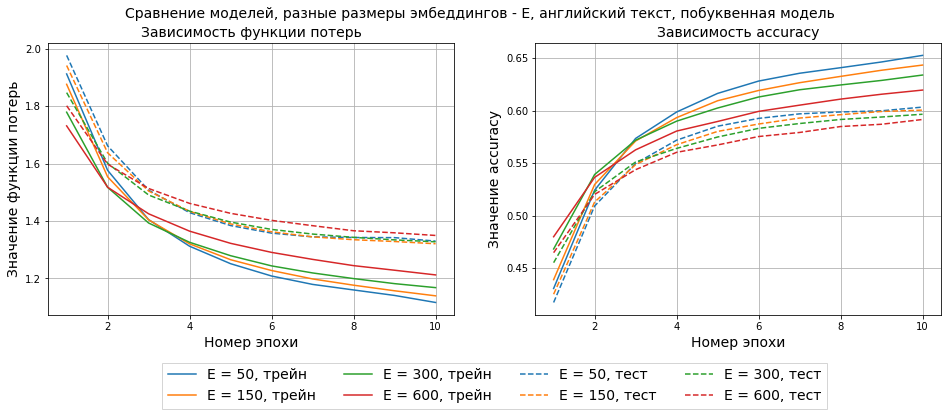

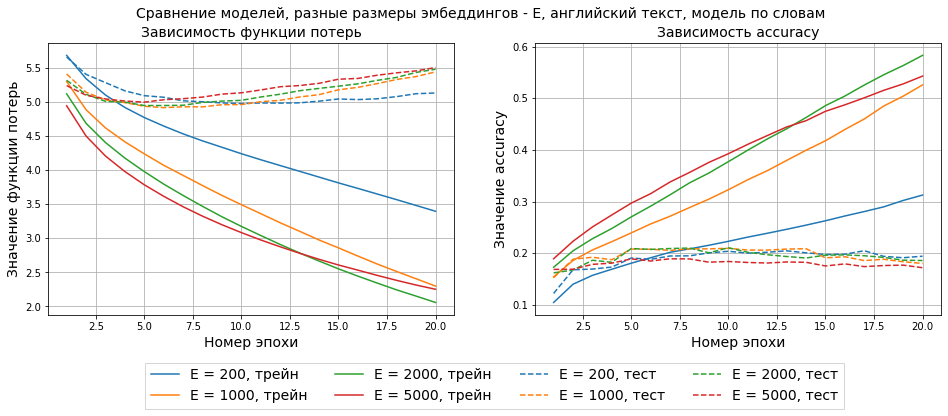

In [11]:
#!g1.1
plot_results(res_char, 4, 'Сравнение моделей, разные размеры эмбеддингов - E, английский текст, побуквенная модель', 
             ['E = {:}'.format(x) for x in kwargs_char['E']], cpu_cuda_troubles=True)
plot_results(res_word, 4, 'Сравнение моделей, разные размеры эмбеддингов - E, английский текст, модель по словам', 
             ['E = {:}'.format(x) for x in kwargs_word['E']], cpu_cuda_troubles=True)

Как видно на графиках, больше - не всегда лучше. 

Для побуквенной модели: малый размер пространства эмбеддингов обеспечивает лучшее качество. Лучшим размером оказался самый малый - 50. Это может показаться логичным, учитывая, что в алфавите всего порядка 30 символов, однако это не всегда так. Это будет продемонстрировано на примере русского языка

Для модели со словами: увеличение размера пространства после некоторого момента ведёт только к переобучению. Качество на трейне растёт очень быстро, а на тесте не изменяется. Однако при совсем малом размере - 200, модель медленно обучается. Обучать 1000 параметров долго, возьмём далее размерность 600. Отметим, что слов в алфавите даже после стемминга - порядка 2.5 тысяч. Поэтому размерность в данном случае нужна намного больше, чем в пером. Также это объясняет, почему качество на трейне растёт с ростом размера эмбеддингов.

#### Эксперимент 2

Определившись с размером эмбеддингов, рассмотрим размерность внутреннего слоя.

1. E = 50, 600 -  для первого / второго случая
2. H - перебирается
3. N = 1
4. D = 0


In [12]:
#!g1.1
kwargs_char['E'], kwargs_word['E'] = [50] * 4, [600] * 4
kwargs_char['H'], kwargs_word['H'] = [100, 400, 700, 1000], [100, 400, 700, 1000]
kwargs_char['lr'], kwargs_word['lr'] = 0.001, 0.0005
res_char = experiment(**kwargs_char)
res_word = experiment(**kwargs_word)

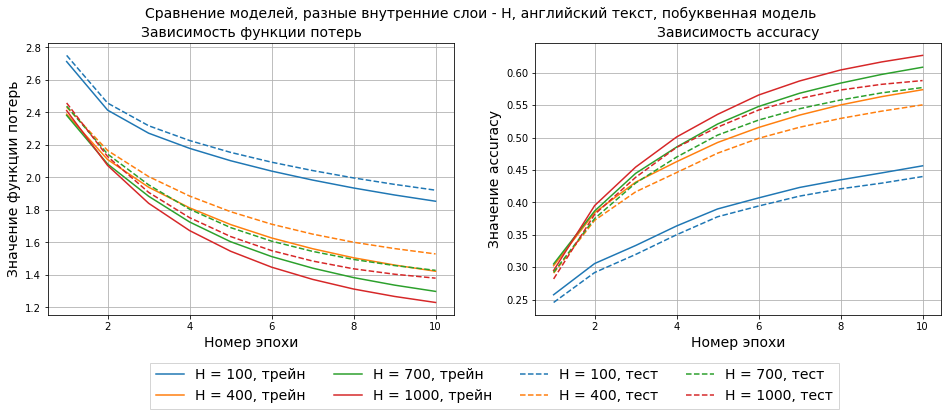

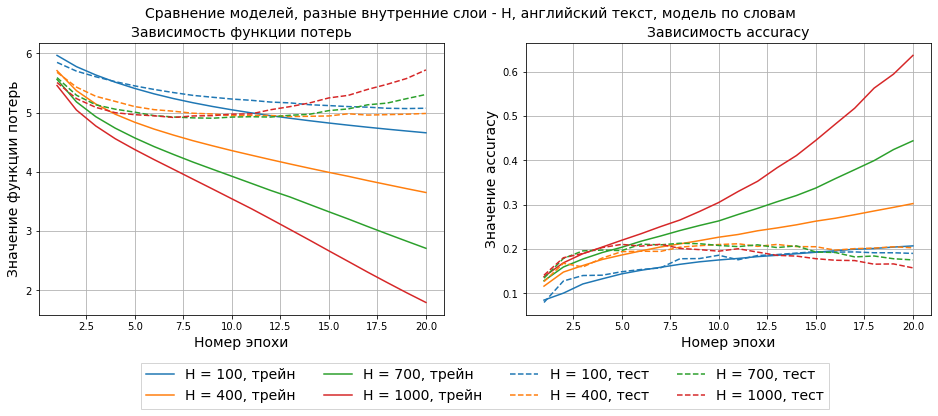

In [13]:
#!g1.1
plot_results(res_char, 4, 'Сравнение моделей, разные внутренние слои - H, английский текст, побуквенная модель', 
             ['H = {:}'.format(x) for x in kwargs_char['H']], cpu_cuda_troubles=True)
plot_results(res_word, 4, 'Сравнение моделей, разные внутренние слои - H, английский текст, модель по словам', 
             ['H = {:}'.format(x) for x in kwargs_word['H']], cpu_cuda_troubles=True)

Максимальный размер скрытого слоя в первом случае соответствует лучшему качеству. Возьмём далее размерность 700, так как дальнейшее её увеличение неэффективно.

В случае предсказания слов всё сложнее: на трейне большое количество параметров действительно обеспечивает хорошее качество, но на тесте ведёт к более быстрому переобучению. В этом случае размерность 400 кажется оптимальной.

### Эксперимент 3

Кроме количества параметоров, в нашем классе можно перебрать разное количество слоёв. В случае нескольких слоёв выходы первой LSTM перенаправляются на входы второй, выходы второй на входы третей и т.д.

Снова обучим два представления.

1. E = 50, 600 - для первого / второго случая
2. H = 700, 400 - для первого / второго случая
3. N - перебирается
4. D = 0


In [14]:
#!g1.1
kwargs_char['H'], kwargs_word['H'] = [700] * 4, [400] * 4
kwargs_char['N'], kwargs_word['N'] = [1, 2, 3, 4], [1, 2, 3, 4]
res_char = experiment(**kwargs_char)
res_word = experiment(**kwargs_word)

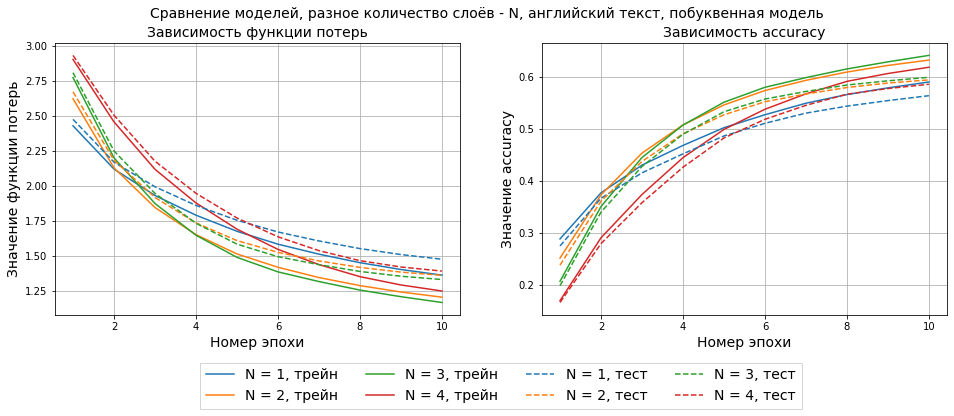

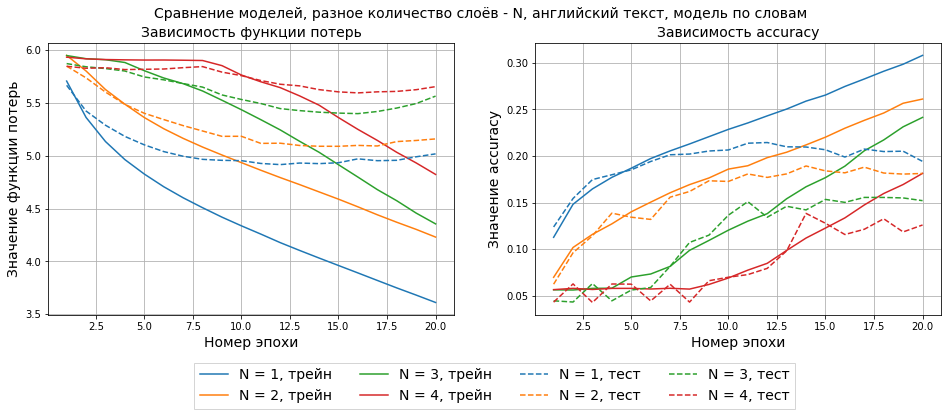

In [15]:
#!g1.1
plot_results(res_char, 4, 'Сравнение моделей, разное количество слоёв - N, английский текст, побуквенная модель', 
             ['N = {:}'.format(x) for x in kwargs_char['N']], cpu_cuda_troubles=True)
plot_results(res_word, 4, 'Сравнение моделей, разное количество слоёв - N, английский текст, модель по словам', 
             ['N = {:}'.format(x) for x in kwargs_word['N']], cpu_cuda_troubles=True)

Результаты говорят о том, что модель с большим числом слоёв обучать сложнее. 

Для побуквенной модели 2-3 слоя показали одинаковое качество. Модель по-прежнему не переобучается.

Для второй - при большом количестве слоёв модель долго обучается. Видно, что  

### Эксперимент 4.1
Рассмотрим дропаут в двух вариациях: сначала для лучших на данный момент моделей, затем для моделей с большим количеством параметров.

На примере посимвольной модели.

1. E = 50, 100 - для лучшей / излишней модели
2. H = 700, 1200 - для лучшей / излишней модели
3. N = 2
4. D - перебирается

In [19]:
#!g1.1
kwargs_char['N'], kwargs_word['N'] = [2] * 4, [1] * 4
kwargs_char['D'], kwargs_word['D'] = [None, 0.05, 0.1, 0.2], [None] * 4
res_char = experiment(**kwargs_char)

kwargs_char['E'] = [kwargs_char['E'][0] + 50] * 4
kwargs_char['H'] = [kwargs_char['H'][0] + 500] * 4
kwargs_char['num_iter'] = 20
res_overfit_char = experiment(**kwargs_char)

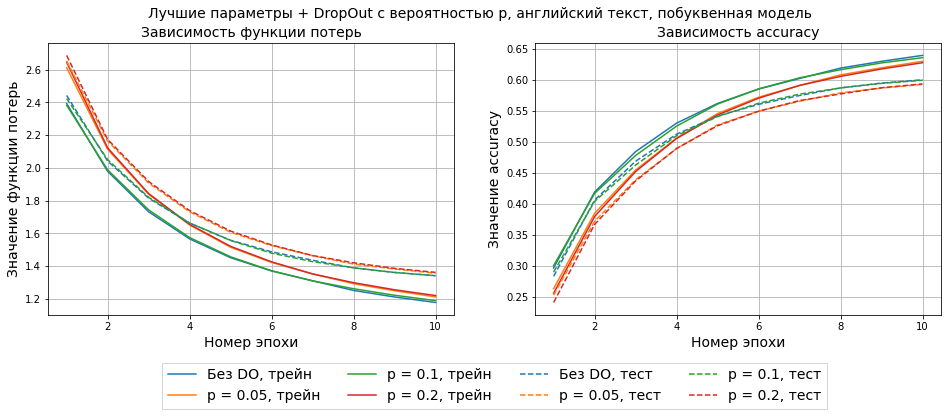

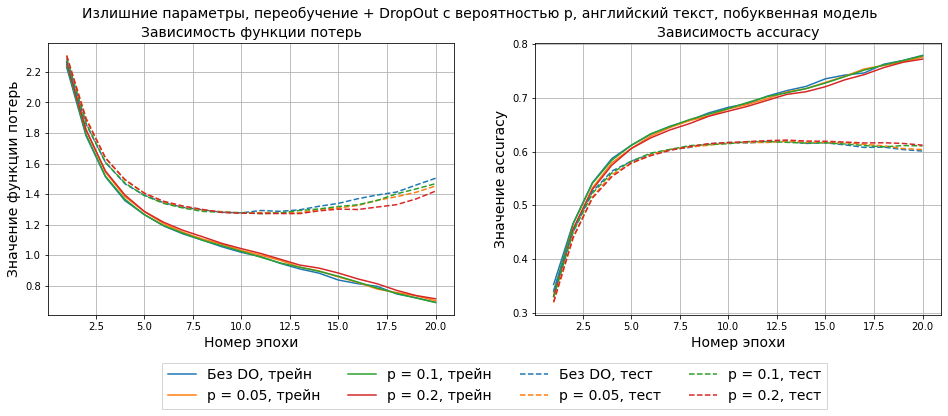

In [25]:
#!g1.1
plot_results(res_char, 4, 'Лучшие параметры + DropOut с вероятностью p, английский текст, побуквенная модель', 
             ['Без DO'] + ['p = {:}'.format(x) for x in kwargs_char['D'][1:]], cpu_cuda_troubles=True)
plot_results(res_overfit_char, 4, 'Излишние параметры, переобучение + DropOut с вероятностью p, английский текст, побуквенная модель', 
             ['Без DO'] + ['p = {:}'.format(x) for x in kwargs_char['D'][1:]], cpu_cuda_troubles=True)

### Эксперимент 4.2

Как мы уже отмечали, модель слов быстро переобучается, попробуем исправить это, добавив сильный DropOut.

На примере  модели слов.

1. E = 600, 1000 - для лучшей / излишней модели
2. H = 400, 700 - для лучшей / излишней модели
3. N = 2
4. D - перебирается

In [22]:
#!g1.1
kwargs_word['N'] = [2] *4
kwargs_word['D'] = [None, 0.05, 0.1, 0.2] 
res_word = experiment(**kwargs_word)

kwargs_word['E'] = [kwargs_word['E'][0] + 300] * 4
kwargs_word['H'] = [kwargs_word['H'][0] + 300] * 4
kwargs_char['num_iter'] = 30
res_overfit_word = experiment(**kwargs_word)

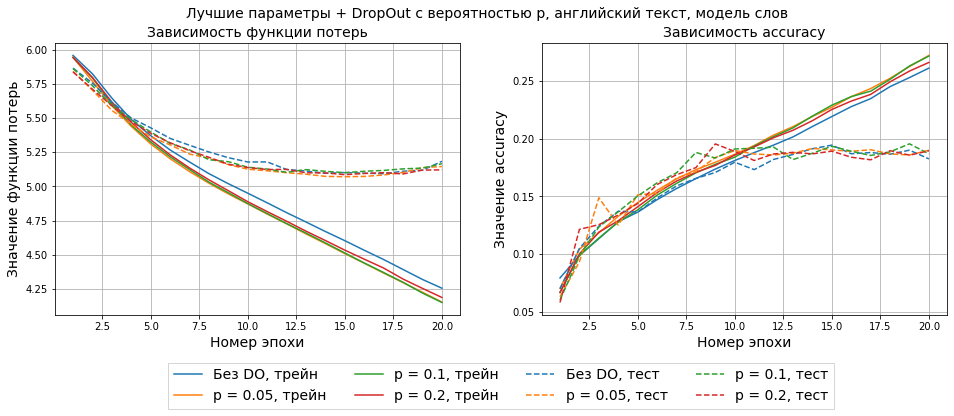

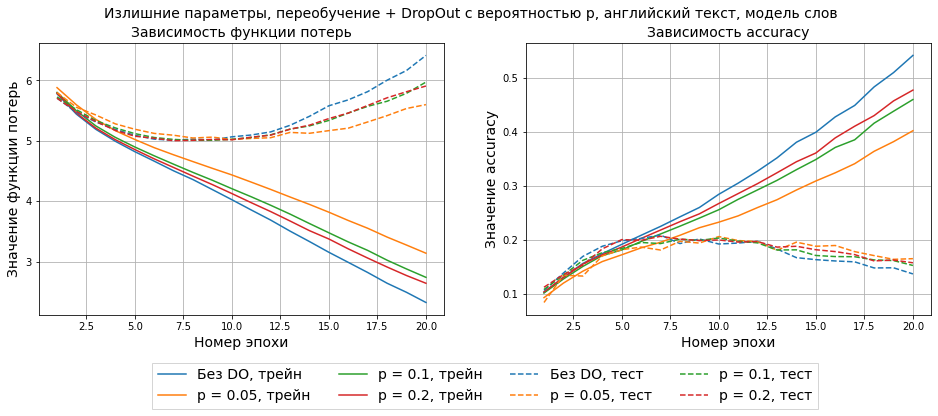

In [26]:
#!g1.1
plot_results(res_word, 4, 'Лучшие параметры + DropOut с вероятностью p, английский текст, модель cлов', 
             ['Без DO'] + ['p = {:}'.format(x) for x in kwargs_word['D'][1:]], cpu_cuda_troubles=True)
plot_results(res_overfit_word, 4, 'Излишние параметры, переобучение + DropOut с вероятностью p, английский текст, модель cлов', 
             ['Без DO'] + ['p = {:}'.format(x) for x in kwargs_word['D'][1:]], cpu_cuda_troubles=True)

Дропаут ни в одном из 4 случаев не принёс пользы. 

### Эксперимент 5

Посмотрим как ведут себя сети на примере русского текста.

Если подобранные параметры покажут значительно лучшее качество, то можно считать, что выводы, сделанные в работе, распостраняются на сами модели, а не конкретный текст и словарь.

In [38]:
#!g1.1
kwargs_ru = {'E': [128, 50, 128, 128], 'H':[256, 256, 600, 256] , 'N': [1, 1, 1, 3], 'D':[0, 0, 0, 0.05], 
               'V': [len(ru_char_encoding.keys())] * 4, 'train':ru_char_train , 'test': ru_char_test, 
               'loss_fn':loss_fn, 'lr': 0.001, 'device': device, 'num_iter':15, 'silent_mode':True}

res_ru = experiment(**kwargs_ru)

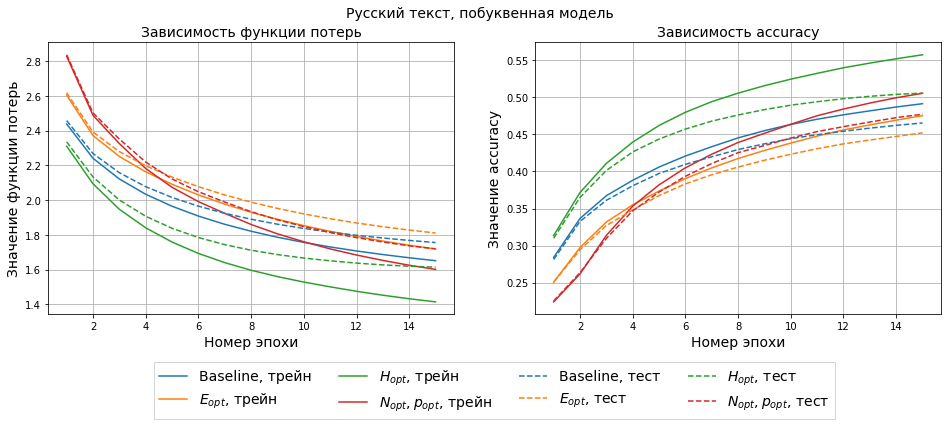

In [39]:
#!g1.1
plot_results(res_ru, 4, 'Русский текст, побуквенная модель', 
             ['Baseline', '$E_{opt}$', '$H_{opt}$', '$N_{opt}, p_{opt}$'], cpu_cuda_troubles=True)

Русский словарь имеет всего на 6 букв больше, чем английский, но размер пространства эмбеддингов для него, как оказалось, нужен намного больше. 
Скорее всего это значит, что для разных словарей и текстов нужны разные размеры эмбеддингов.

Теперь посмотрим как наши модели генериуют текст.

## Часть 2, генерация текста

###  1: Генерация английских букв

Обучим модель на лучших параметрах, сгененрируем для неё текст на обучающей и на тестовой выборках.

In [10]:
#!g1.1
kwargs = {'E': 50, 'H': 600, 'N': 2, 'D':None, 'V': len(eng_char_encoding.keys()),
          'train':eng_char_train , 'test': eng_char_test, 'loss_fn':loss_fn, 
          'lr': 0.001, 'device': device, 'num_iter':15, 'silent_mode': True}

model_eng_char = get_train_model(**kwargs)

In [14]:
#!g1.1
experiment_gen([eng_char_text[140_000:140_100], eng_char_text[-140_086:-139_999]], True, 150, eng_char_encoding, eng_char_decoding, model_eng_char, device)

<------------ k = 1 ------------>
 highly condensed form, with two objects in view. the first is to show the general manner in which s   ----- генерация ----->
hould be a substantial adviser what has a substantial price of the stock market in the stock market in the stock market in the stock market in the sto
<------------ k = 2 ------------>
 highly condensed form, with two objects in view. the first is to show the general manner in which s   ----- генерация ----->
hould be about the standard poor s stock warrants are not a profit of the security analyst on the conventional companies were a subsequal to succeed a
<------------ k = 3 ------------>
 highly condensed form, with two objects in view. the first is to show the general manner in which s   ----- генерация ----->
hows that a graham investor. in these, asset value of these several such is they are not only as to think that a common shares, we must be a so often 
<------------ k = 5 ------------>
 highly condensed form, with two 

В клетке выше показан вывод для двух отрезков: из обучающей выборки и из тестовой. 

Отметим, что тексты для малых k состоят из слов, нет неосмысленных комбинаций символов.

1. При k = 1 оба текста  сначала генерируются нормально, а затем начинается череда фраз < in the stock market >. Это не случайно, в тексте данная фраза встречается очень часто.
2. При k=2, 3 текст генерируется с нормальными язоковыми конструкциями, но в итоге получается не осмысленный.
3. При k=5 конструкции осмысленны, но местами появляются ошибки в словах. Например, 'strettempted'.
4. При больших k текст имеет всё больше ошибок.

In [15]:
#!g1.1
kwargs = {'E': 200, 'H': 1000, 'N': 2, 'D':None, 'V': len(eng_char_encoding.keys()),
          'train':eng_char_train , 'test': eng_char_test, 'loss_fn':loss_fn, 
          'lr': 0.001, 'device': device, 'num_iter':30, 'silent_mode': True}

model_eng_char_overfit = get_train_model(**kwargs)

In [17]:
#!g1.1
experiment_gen([eng_char_text[140_000:140_100], eng_char_text[-140_100:-140_000]], True, 150, eng_char_encoding, eng_char_decoding, model_eng_char_overfit, device)

<------------ k = 1 ------------>
 highly condensed form, with two objects in view. the first is to show the general manner in which s   ----- генерация ----->
tocks selling at only times the returns of all these this is one of the thousands of the past ten years, all these factors are the change. if a compan
<------------ k = 2 ------------>
 highly condensed form, with two objects in view. the first is to show the general manner in which s   ----- генерация ----->
tocks selling at only times its five year an earnings that would not be taken as projusiasionariety of the convertible issues in the stock guide, and 
<------------ k = 3 ------------>
 highly condensed form, with two objects in view. the first is to show the general manner in which s   ----- генерация ----->
tocks selling at, with corporate managers but less than the chances of stock market places of the former tax concerns, or annual report offs, or commo
<------------ k = 5 ------------>
 highly condensed form, with two 

Для переобученной модели ситуация другая:

На обучающей выборке текст теперь более осмысленный, но в начале повторяется. Вероятно модель заучила первую часть предложения.

На тестовой выборке текст тоже стал не хуже. Хотя точность на нём не получилась хорошей, удалось перенести конструкции с обучающей выборки.

###  2: русский текст, посимвольное кодирование

In [20]:
#!g1.1
kwargs = {'E': 50, 'H':600, 'N': 2, 'D': 0.05, 'V': len(ru_char_encoding.keys()),
          'train':ru_char_train , 'test': ru_char_test, 'loss_fn':loss_fn, 
          'lr': 0.001, 'device': device, 'num_iter':15, 'silent_mode':True}

model_ru_char = get_train_model(**kwargs)

In [23]:
#!g1.1
experiment_gen([ru_char_text[140_002:140_102], ru_char_text[-141_100:-141_000]], True, 150, ru_char_encoding, ru_char_decoding, model_ru_char, device)

<------------ k = 1 ------------>
 во дворе крадут. куб у меня дров куплен. следить надо. илья иваныч с отчаянием махнул рукой. чего ж   ----- генерация ----->
е так вот он подобное представление и вот он подобное представление и вот он подобное представление и вот он подобное представление и вот он подобное 
<------------ k = 2 ------------>
 во дворе крадут. куб у меня дров куплен. следить надо. илья иваныч с отчаянием махнул рукой. чего ж   ----- генерация ----->
е это такое собственно странно подумала, что она не могла из подумать от этого, например, в требуется в силу волнения с ней подошла. но только на это 
<------------ k = 3 ------------>
 во дворе крадут. куб у меня дров куплен. следить надо. илья иваныч с отчаянием махнул рукой. чего ж   ----- генерация ----->
е так давет однажды все таки скрыла все это такое подумает, как бы обратно получается и на какой то то время выступает, и в которых он подошел какие, 
<------------ k = 5 ------------>
 во дворе крадут. куб у меня дров

Вообще говоря, к русскому тексту можно отнести те же самые замечания, что и к английскому. 

Результаты генерации похожи своими недостатками: У алгоритма есть любимая фраза < подобное представление >.
Снова конструкции имеют смысл локально, но составляют неосмысленный текст. 

Однако результат для английского текста был лучше, всё-таки русский язык намного сложнее. Тем более стиль Зощенко сочетает сразу повествование и диалоги, что ухудшает качество. Этот конфликт стилей хорошо заметен. 

###  3: Английский текст, кодирование по словам 

In [26]:
#!g1.1
kwargs = {'E': 600, 'H':400, 'N': 1, 'D':None, 'V': len(eng_word_encoding.keys()),
          'train':eng_word_train , 'test': eng_word_test, 'loss_fn':loss_fn, 
          'lr': 0.0005, 'device': device, 'num_iter':20, 'silent_mode':True}

model_eng_word = get_train_model(**kwargs)

In [37]:
#!g1.1
experiment_gen ([eng_word_text[24_000:24_015], eng_word_text[-24_015: -24_000]], False, 20, eng_word_encoding, eng_word_decoding, model_eng_word, device)

<------------ k = 1 ------------>
debt with dollar that have been by inflat . complet inflat run against the econom   ----- генерация ----->
of the compani s stock had been to a . in the case of the stock market , the most
<------------ k = 2 ------------>
debt with dollar that have been by inflat . complet inflat run against the econom   ----- генерация ----->
of the market s and , as it wa to a good deal to be a better than the market
<------------ k = 3 ------------>
debt with dollar that have been by inflat . complet inflat run against the econom   ----- генерация ----->
and of the market and the enterpris . the investor should have been the same as a whole , as
<------------ k = 5 ------------>
debt with dollar that have been by inflat . complet inflat run against the econom   ----- генерация ----->
of the secur analyst , and a good part of hi money to be the right to buy and sell
<------------ k = 10 ------------>
debt with dollar that have been by inflat . complet inflat run aga

Отметим особенности top-k семплирования для случая словарного представления.

1. k = 1 - уже нет повторений, текст получается более осмысленным, но имеет мало отношения к первой части.
2. k = 2,3,5 - текст достаточно осмысленный, конструкции неплохо получаются
3. k $\ge$ 10 - текст слишком хаотический.

Разница на обучении и тести не очень заметна.

Теперь переобучим модель:

In [38]:
#!g1.1
kwargs = {'E': 1000, 'H':1000, 'N': 1, 'D':None, 'V': len(eng_word_encoding.keys()),
          'train':eng_word_train , 'test': eng_word_test, 'loss_fn':loss_fn, 
          'lr': 0.0005, 'device': device, 'num_iter':40, 'silent_mode':True}

model_eng_word = get_train_model(**kwargs)

In [39]:
#!g1.1
experiment_gen([eng_word_text[24_000:24_015], eng_word_text[-24_015: -24_000]], False, 20, eng_word_encoding, eng_word_decoding, model_eng_word, device)

<------------ k = 1 ------------>
debt with dollar that have been by inflat . complet inflat run against the econom   ----- генерация ----->
self interest of ani govern , the secur analyst to protect hi client interest or secur analysi to be ani
<------------ k = 2 ------------>
debt with dollar that have been by inflat . complet inflat run against the econom   ----- генерация ----->
self interest of ani govern , the investor who have to the stock , or he own right for the
<------------ k = 3 ------------>
debt with dollar that have been by inflat . complet inflat run against the econom   ----- генерация ----->
self interest of ani govern , the bond investor to stock pick . for the stock market , you can
<------------ k = 5 ------------>
debt with dollar that have been by inflat . complet inflat run against the econom   ----- генерация ----->
self interest of ani govern , the secur analyst who talk to peopl who tri to pick stock pick and
<------------ k = 10 ------------>
debt with dol

При переобучении данной модели качество стало сильно хуже.

На обучающей выборке продолжение предложения было запомнено, однако в остальном текст стал хуже.
Генерация на тестовой выборке получилась хуже прежней, местами проскакивает бессмыслица.

Отличие от переобучения в первом случае объясняется графиками, которые мы строили ранее. При переобучении посимвольной модели переобучение на них было заметно намного слабее, чем для второй модели.

### Заключение

В данной работе были рассмотрены и оптимизированы параметры языковых моделей на LSTM.

Также был продемонстрирован генерируемый текст. Показаны существенные отличия посимвольного и словарного кодирования.